<a href="https://colab.research.google.com/github/HunchPounch/Classic_ML_notebooks/blob/main/HousePrices_EDA_FE_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Prices kaggle competition

В соревновании необходимо предсказать цены домов на основе предоставленных данных. Применим EDA и feature engineering и различные модели для получения хороших результатов

[ссылка на соревнование](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview
)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge

from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
train = pd.read_csv('drive/MyDrive/data/h_train.csv')
test = pd.read_csv('drive/MyDrive/data/h_test.csv')

## EDA
Можно проследить, что цены на новые постройки выше

<Axes: xlabel='YearBuilt', ylabel='SalePrice'>

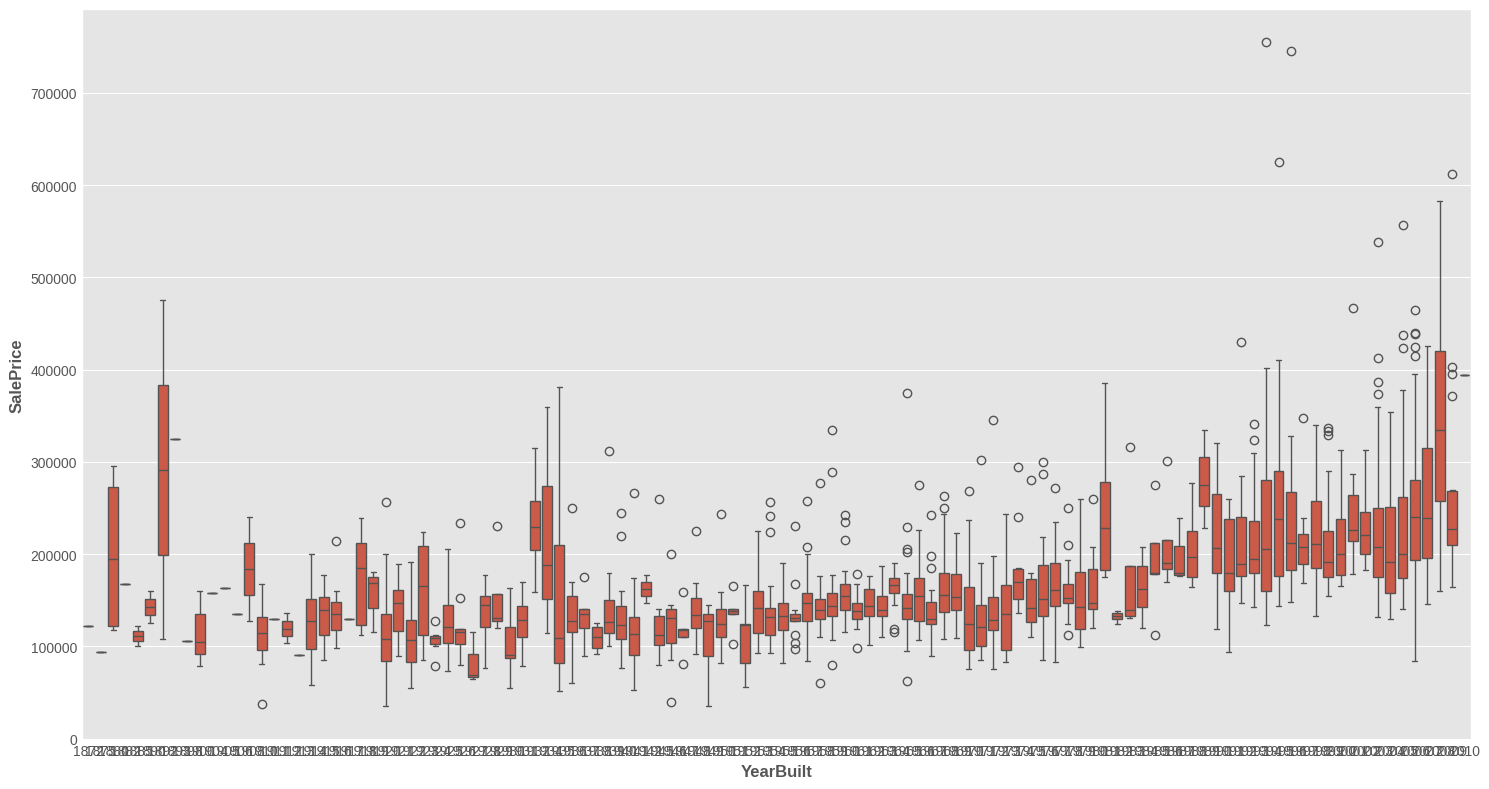

In [17]:
plt.figure(figsize=(15,8))
sns.boxplot(x='YearBuilt', y='SalePrice', data=train)

Можно увидеть два явных выброса справа, удалим их

(0.0, 800000.0)

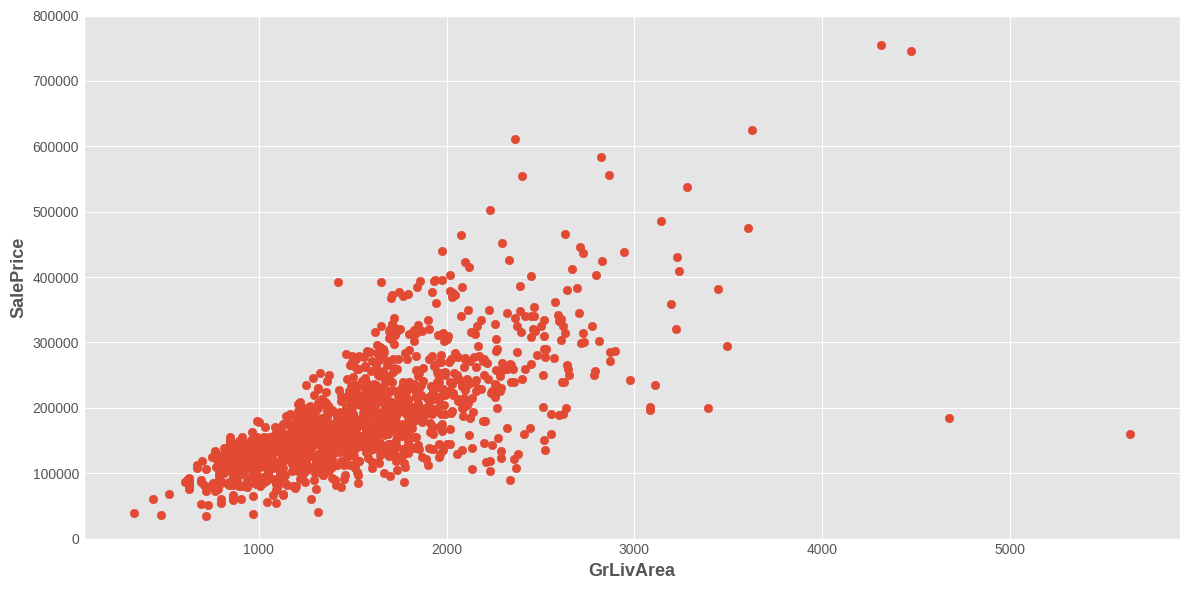

In [18]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [19]:
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)

In [20]:
full=pd.concat([train,test], ignore_index=True)

In [21]:
full.drop(['Id'],axis=1, inplace=True)
full.shape

(2917, 80)

## Data Cleaning

In [24]:
# пропущенные значения
aa = full.isna().sum()
aa[aa>0].sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
MasVnrType      1766
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
GarageCars         1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
Electrical         1
dtype: int64

In [25]:
full.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.153409   64.5   176
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

In [26]:
full["LotAreaCut"] = pd.qcut(full.LotArea,10)

In [27]:
full.groupby(['LotAreaCut'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4921.8]    35.741036   34.0   251
(4921.8, 7007.2]      55.460674   52.0   267
(7007.2, 7949.0]      62.959839   62.0   249
(7949.0, 8740.4]      67.113725   65.0   255
(8740.4, 9452.0]      69.959184   70.0   245
(9452.0, 10148.8]     73.988235   75.0   255
(10148.8, 11000.0]    73.636364   75.0   253
(11000.0, 12196.8]    83.371681   82.0   226
(12196.8, 14285.8]    84.973684   85.0   228
(14285.8, 215245.0]   92.846535   90.0   202

In [28]:
full['LotFrontage']=full.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [29]:
full['LotFrontage']=full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

Заполняем остальные пропущенные значения в соотсветствии с data_description.txt

In [30]:
cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    full[col].fillna(0, inplace=True)

In [31]:
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    full[col].fillna("None", inplace=True)

In [32]:
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    full[col].fillna(full[col].mode()[0], inplace=True)

In [34]:
full.isnull().sum()[full.isna().sum()>0]

SalePrice    1459
dtype: int64

## Pipeline

In [35]:
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    full[col]=full[col].astype(str)

In [37]:
full.drop("LotAreaCut",axis=1,inplace=True)
full.drop(['SalePrice'],axis=1,inplace=True)

Закодируем годовые признаки, так как они, как было показано выше, влияют на цену

In [38]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        return X

In [39]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

In [40]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [42]:
full2 = full.copy()

In [43]:
data_pipe = pipe.fit_transform(full2)

In [44]:
data_pipe.shape

(2917, 383)

In [45]:
data_pipe.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,9.042040,7,5,110,53,5.283204,706.0,0.0,150.0,...,False,False,False,True,False,False,False,False,True,False
1,80.0,9.169623,6,8,83,26,0.000000,978.0,0.0,284.0,...,False,False,False,True,False,False,False,False,True,False
2,68.0,9.328212,7,5,108,52,5.093750,486.0,0.0,434.0,...,False,False,False,True,False,False,False,False,True,False
3,60.0,9.164401,7,5,25,20,0.000000,216.0,0.0,540.0,...,False,False,False,True,True,False,False,False,False,False
4,84.0,9.565284,8,5,107,50,5.860786,655.0,0.0,490.0,...,False,False,False,True,False,False,False,False,True,False


In [46]:
scaler = RobustScaler()

In [47]:
n_train=train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

## Feature Selection

In [48]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

Lasso(alpha=0.001)

In [49]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)

In [50]:
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
OverallQual,0.110718
YearBuilt,0.097886
GrLivArea,0.096007
2ndFlrSF,0.091007
Neighborhood_Crawfor,0.082668
...,...
KitchenAbvGr_2,-0.031972
MSZoning_RM,-0.035655
CentralAir_N,-0.037160
SaleCondition_Abnorml,-0.056980


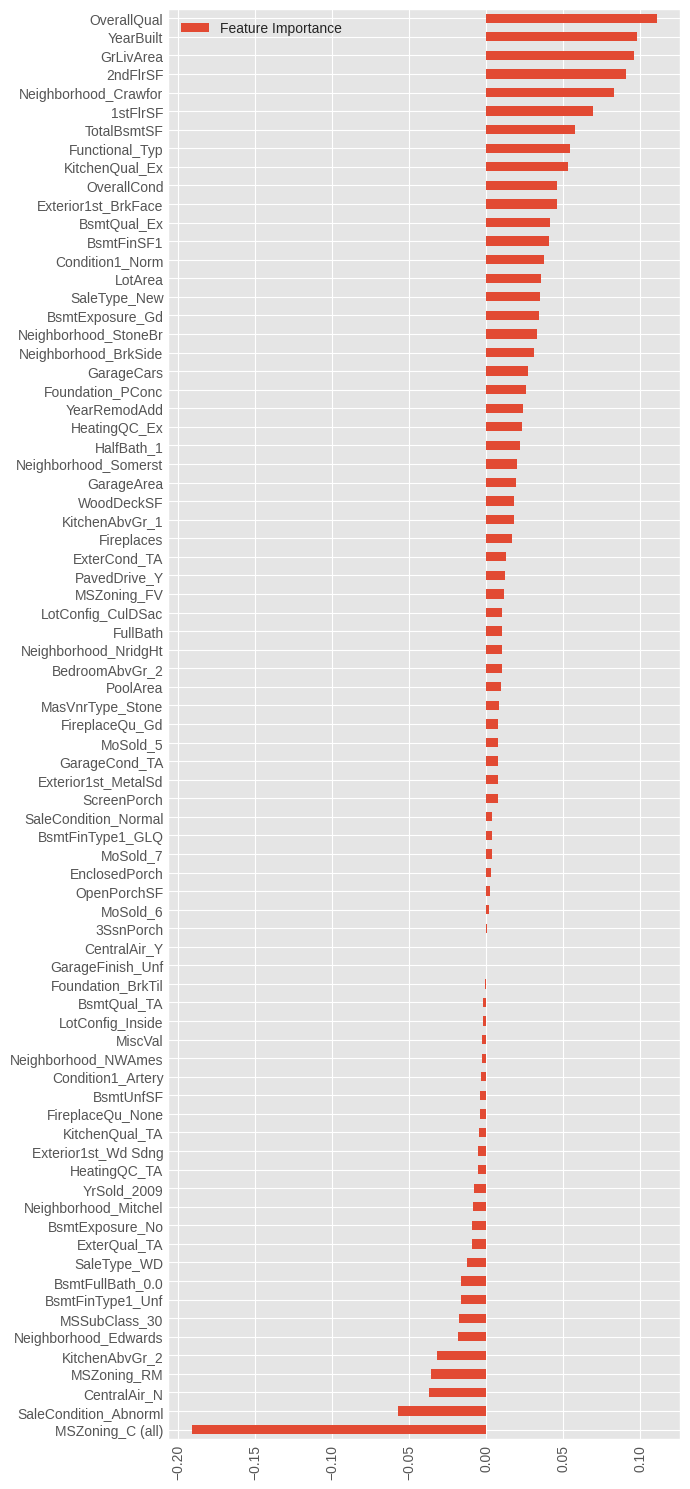

In [52]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(7,15))
plt.xticks(rotation=90)
plt.show()

In [59]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]

        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]

            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]

            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]

            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]


            return X

In [60]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=2)),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

### PCA

In [67]:
full_pipe = pipe.fit_transform(full)

In [68]:
full_pipe.shape

(2917, 394)

In [69]:
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

In [70]:
pca = PCA(n_components=375)

In [71]:
X_scaled=pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)

In [72]:
X_scaled.shape, test_X_scaled.shape

((1458, 375), (1459, 375))

## Models

In [73]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [74]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [75]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 17598160065.867729, 14801421086.2911
Ridge: 0.117479, 0.0087
Lasso: 0.129526, 0.0056
RF: 0.144433, 0.0051
GBR: 0.133590, 0.0062
SVR: 0.137707, 0.0110
LinSVR: 0.120814, 0.0102
Ela: 0.114272, 0.0063
SGD: 0.143868, 0.0086
Bay: 0.111965, 0.0066
Ker: 0.111651, 0.0062
Extra: 0.139054, 0.0048
Xgb: 0.147387, 0.0047


Подберем гиперпараметры

In [76]:
class grid():
    def __init__(self,model):
        self.model = model

    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [77]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0009],'max_iter':[10000]})

{'alpha': 0.0004, 'max_iter': 10000} 0.11441713672602596
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.114417        0.001527
1  {'alpha': 0.0005, 'max_iter': 10000}         0.114517        0.001456
2  {'alpha': 0.0007, 'max_iter': 10000}         0.114841        0.001426
3  {'alpha': 0.0009, 'max_iter': 10000}         0.115393        0.001461


In [78]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 35} 0.11214314671409369
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.112143        0.001419
1  {'alpha': 40}         0.112273        0.001418
2  {'alpha': 45}         0.112416        0.001418
3  {'alpha': 50}         0.112566        0.001419
4  {'alpha': 55}         0.112722        0.001422
5  {'alpha': 60}         0.112880        0.001424
6  {'alpha': 65}         0.113041        0.001427
7  {'alpha': 70}         0.113203        0.001430
8  {'alpha': 80}         0.113527        0.001435
9  {'alpha': 90}         0.113849        0.001441


In [79]:
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 15, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'} 0.10943493868153836
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.110662   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.109897   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.110640   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.109875   
4   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.110309   
5   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.109679   
6   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.110335   
7   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.109672   
8   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.110043   
9   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.109448   
10  {'C': 15, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.110035   
11  {'C': 15, 'epsilon': 0.009

In [80]:
param_grid={'alpha':[0.2,0.3,0.4], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1]}
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kernel': 'polynomial'} 0.10998571081600708
                                              params  mean_test_score  \
0  {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.110348   
1  {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.109986   
2  {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.111181   
3  {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.110397   
4  {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.112080   
5  {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.110904   

   std_test_score  
0        0.001429  
1        0.001424  
2        0.001434  
3        0.001419  
4        0.001444  
5        0.001423  


In [81]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3],'max_iter':[10000]})

{'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter': 10000} 0.11352720054437432
                                              params  mean_test_score  \
0  {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.115068   
1  {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.114725   
2  {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.113896   
3  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.113527   
4  {'alpha': 0.004, 'l1_ratio': 0.1, 'max_iter': ...         0.113873   
5  {'alpha': 0.004, 'l1_ratio': 0.3, 'max_iter': ...         0.116313   
6  {'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter':...         0.113807   
7  {'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': ...         0.114153   
8  {'alpha': 0.005, 'l1_ratio': 0.3, 'max_iter': ...         0.117115   

   std_test_score  
0        0.001783  
1        0.001744  
2        0.001617  
3        0.001487  
4        0.001455  
5        0.001520  
6        0.001445  
7        0.001413  
8        0.0015

## Ensemble


In [83]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight

    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self

    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])

        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [84]:
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

In [85]:
# веса на основе gridsearch score
w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2

In [86]:
weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])

In [87]:
score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.1095619725775493


Но усредним две лучшие модели и получим лучший скор

In [122]:
weight_avg = AverageWeight(mod = [svr,ker],weight=[0.5,0.5])

In [121]:
score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.10839905714394608


## Submission

In [123]:
weight_avg.fit(X_scaled,y_log)

AverageWeight(mod=[SVR(C=13, epsilon=0.009, gamma=0.0004),
                   KernelRidge(alpha=0.2, coef0=0.8, kernel='polynomial')],
              weight=[0.5, 0.5])

In [126]:
pred = np.exp(weight_avg.predict(test_X_scaled))

In [127]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("submission.csv",index=False)